# Preprocesamiento

## Leer y procesar base de datos

De la base de datos tenemos la siguiente información sobre los atributos:
   1. __survival__: número de meses que el paciente ha sobrevió o ha sobrevivido si sigue vivo. Como todos los pacientes tuvieron infartos en diferentes edades, es posible que unos hayan sobrevivido menos del año pero siguen vivos. Revise la segunda variable para verificarlo. Tales pacientes no pueden ser utilizados para la tarea de predicción.
   2. __still-alive__: variable binaria.  0 significa muerte tras el periodo de supervivencia, 1 significa que sigue vivo
   3. __age-at-heart-attack__: edad en años de la ocurrencia del infarto
   4. __pericardial-effusion__: binario. Efusión pericardial es fluido alrededor del corazón.  0=sin fluido, 1=con fluido
   5. __fractional-shortening__: una medida de la contractibilidad alrededor del corazón, números bajos son incrementalmente anormales.
   6. __epss__: E-point septal separation, otra medida de contractibilidad. Números altos son incrementalmente anormales.
   7. __lvdd__: left ventricular end-diastolic dimension. Esta es una medida del tamaño del corazón en la diastólica. Corazones grandes tienden a estar enfermos.
   8. __wall-motion-score__: una medida de cómo se están moviendo los segmentos del ventrículo izquierdo.
   9. __wall-motion-index__: igual a wall-motion-score dividido por el número de segmentos vistos. Usualmente 12-13 segmentos son vistos en un ecocardiograma Use esta variable EN LUGAR DE wall-motion-score.
   10. __mult__: una variable derivada que puede ser ignorada.
   11. __name__: el nombre del paciente (He reemplazado con "name").
   12. __group__: irrelevante, ignórela.
   13. __alive-at-1__: boleano. Derivado de los primeros dos atributos. 0 significa que el paciente o estaba muerto después de un año o fue seguido per menos de un año.  1 significa que el paciente estaba vivo al año.


Leemos el archivo `*.data` y lo guardamos en un *data frame*

In [1]:
import numpy as np
import pandas as pd

names = ['survival', 'still_alive', 'age_at_heart_attack', 'pericardial_effusion',
         'fractional_shortening', 'epss', 'lvdd', 'wall_motion_score',
         'wall_motion_index', 'mult', 'name', 'group', 'alive_at_1']
data = pd.DataFrame(np.genfromtxt('../data/echocardiogram.data', delimiter=','), columns=names)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
survival                 130 non-null float64
still_alive              131 non-null float64
age_at_heart_attack      127 non-null float64
pericardial_effusion     131 non-null float64
fractional_shortening    124 non-null float64
epss                     117 non-null float64
lvdd                     121 non-null float64
wall_motion_score        128 non-null float64
wall_motion_index        131 non-null float64
mult                     128 non-null float64
name                     0 non-null float64
group                    110 non-null float64
alive_at_1               74 non-null float64
dtypes: float64(13)
memory usage: 13.5 KB
None


Como vemos no todas las columnas son útiles debido a la falta de valores, como la columna `names` que no contiene un solo valor de utilidad. Así eliminamos las columnas `'wall_motion_score','mult', 'name', 'group'`.
 - La primera porque el autor lo indica.
 - Las siguientes tres no contienen información nueva o relevante.
 
Además, hay pacientes que tienen un seguimiento menor al año pero siguen vivos. Descartamos estos pacientes pues (como lo indica la información del autor) no pueden ser utilizados para la tarea en mano.

In [2]:
data = data.drop(['wall_motion_score','mult', 'name', 'group'], axis=1)
indexNames = data[ (data['survival'] < 12) & (data['still_alive'] == 1) ].index
data.drop(indexNames, inplace=True)

Nos interesa la información de la última columna `alive_at_1` pero está incompleta. Utilizamos la información de las primeras dos columnas para completarla de modo que todos los pacientes que han sobrevivido $<12$ se les asigna 0.  Finalmente eliminamos todas las __instancias__ que contienen `NaN` que, por lo tanto, no son útiles.

In [3]:
for i in range( len(data['survival'].values) ):
    if (data['survival'].values[i] < 12):
        data['alive_at_1'].values[i] = 0
    else:
        data['alive_at_1'].values[i] = 1

data.dropna(inplace=True)
display(data)
data['alive_at_1'].value_counts()

,survival,still_alive,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_index,alive_at_1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,1.000,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,1.700,1.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,1.000,1.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,1.450,1.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,2.250,1.0
...,...,...,...,...,...,...,...,...,...
126,21.0,0.0,61.0,0.0,0.140,25.500,5.160,1.270,1.0
128,41.0,0.0,64.0,0.0,0.280,5.400,5.470,1.100,1.0
129,36.0,0.0,69.0,0.0,0.200,7.000,5.050,1.210,1.0
130,22.0,0.0,57.0,0.0,0.140,16.100,4.360,1.360,1.0


1.0    79
0.0     3
Name: alive_at_1, dtype: int64

Se observa que hay tres casos de fallecimiento antes del año.
***
Graficamos la base de datos para ver posibles relaciones lineales entre atributos. 

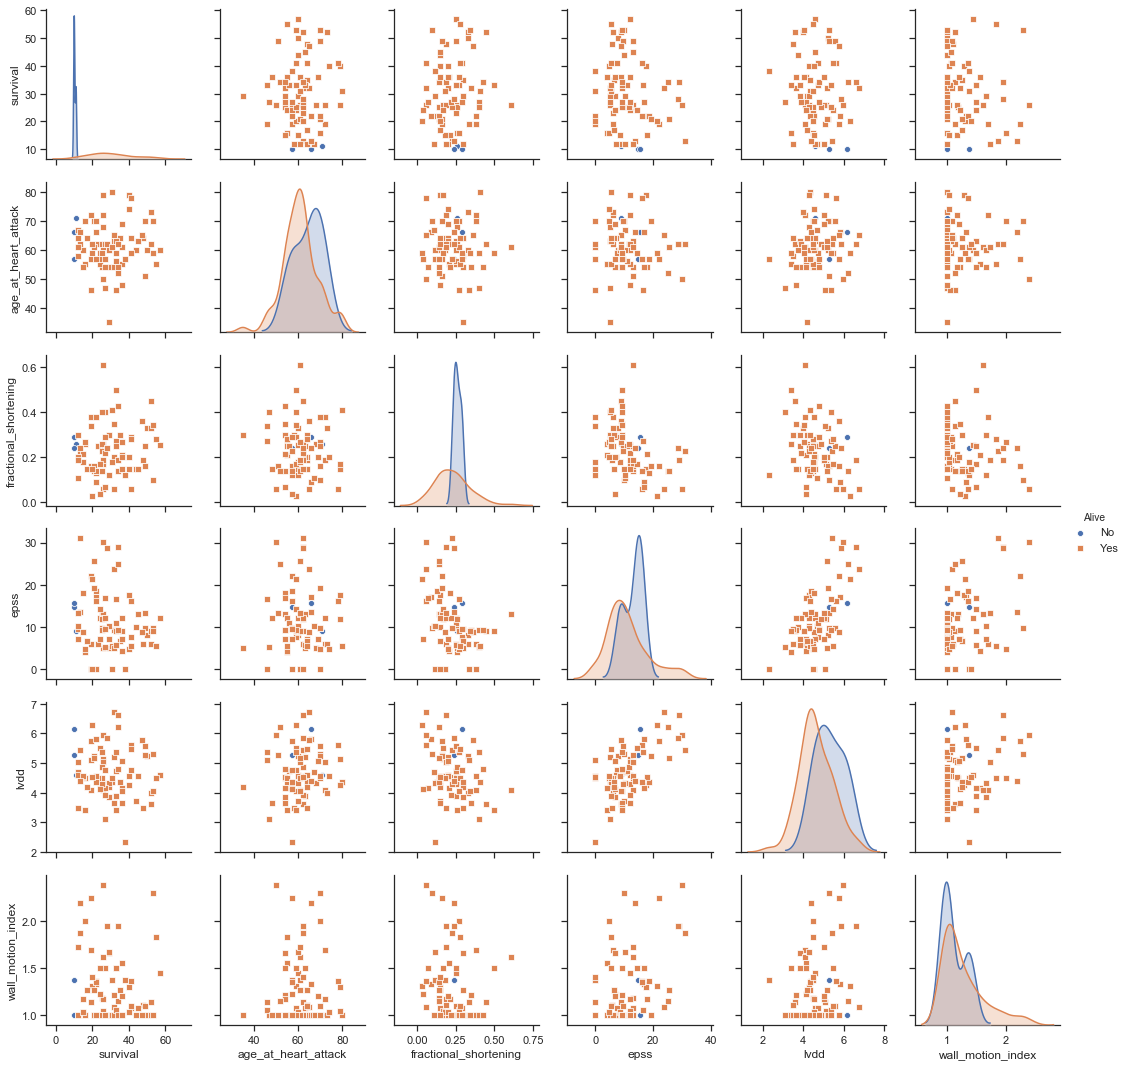

In [4]:
# Plot data_frame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="ticks")
s = sns.pairplot(data, hue='alive_at_1', markers=["o", "s"], vars=['survival', 
                'age_at_heart_attack', 'fractional_shortening','epss', 'lvdd', 'wall_motion_index'])

new_title = 'Alive'              # Change legend label
s._legend.set_title(new_title)
new_labels = ['No', 'Yes']

for t, l in zip(s._legend.texts, new_labels):
    t.set_text(l)
plt.show();

## Preparar datos para entrenamiento

Como nos interesa si el paciente vivirá más del año, nos fijaremos en la columna `survival` que nos indica el número de meses que el paciente ha vivido o vivió después del infarto.

In [ ]:
from sklearn.model_selection import train_test_split
x = data[['age_at_heart_attack', 'fractional_shortening', 'epss', 'lvdd', 
          'wall_motion_index', 'pericardial_effusion', 'still_alive']]
y = data[['survival']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True)

El número de nodos de entrada (o neuronas de paso) será igual al número de atributos, i.e. siete. Luego proponemos una red pequeña con tres capas de 16, 8 y 4 neuronas y una en la salida que indicará el número de meses que se pronostica vivirá el paciente.

In [ ]:
n_input = 7     # input layer (7 columns/features)
n_hidden1 = 16  # 1st hidden layer
n_hidden2 = 8   # 2nd hidden layer
n_hidden3 = 4   # 3rd hidden layer
n_output = 1    # output layer (survival time)

learning_rate = 1e-4
n_iterations = 200
batch_size = 32
dropout = 0.5

In [ ]:
import tensorflow as tf
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
keep_prob = tf.placeholder(tf.float32) 

weights = {
    'w1': tf.Variable(tf.random.normal([n_input, n_hidden1], stddev=0.1)),
    'w2': tf.Variable(tf.random.normal([n_hidden1, n_hidden2], stddev=0.1)),
    'w3': tf.Variable(tf.random.normal([n_hidden2, n_hidden3], stddev=0.1)),
    'out': tf.Variable(tf.random.normal([n_hidden3, n_output], stddev=0.1)),
}

biases = {
    'b1': tf.Variable(tf.constant(1., shape=[n_hidden1])),
    'b2': tf.Variable(tf.constant(1., shape=[n_hidden2])),
    'b3': tf.Variable(tf.constant(1., shape=[n_hidden3])),
    'out': tf.Variable(tf.constant(1., shape=[n_output]))
}


layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
#layer_drop = tf.nn.dropout(layer_3, keep_prob)
output_layer = tf.matmul(layer_3, weights['out']) + biases['out']

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=output_layer))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_pred = tf.equal(tf.argmax(output_layer, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


cost_summary = tf.summary.scalar("cost",cross_entropy)
acc_summary = tf.summary.scalar("accuracy",accuracy)
# Merge all summaries
all_summary = tf.summary.merge_all()
# Summary writer
writer = tf.summary.FileWriter("Tensorboard", sess.graph)

In [ ]:
# train on mini batches
for i in range(n_iterations):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    sess.run(train_step, feed_dict={X: batch_x, Y: batch_y, keep_prob:dropout})

    # print loss and accuracy (per minibatch)
    if i%100==0:
        summary_results,minibatch_loss, minibatch_accuracy = sess.run([all_summary, cross_entropy, accuracy], feed_dict={X: batch_x, Y: batch_y, keep_prob:1.0})
        print("Iteration", str(i), "\t| Loss =", str(minibatch_loss), "\t| Accuracy =", str(minibatch_accuracy))
        
        writer.add_summary(summary_results,i)
        
test_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob:1.0})
print("\nAccuracy on test set:", test_accuracy)